In [36]:
!gpustat

blade.seas.upenn.edu  Mon Oct  4 14:58:27 2021  455.45.01
[0] RTX A6000        | 30'C,   0 % | 45286 / 48685 MB | wangh19(45283M)
[1] RTX A6000        | 78'C, 100 % | 44508 / 48685 MB | sifanw(44505M)
[2] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[3] RTX A6000        | 26'C,   0 % |     1 / 48685 MB |
[4] RTX A6000        | 26'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 25'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[7] RTX A6000        | 26'C,   0 % |     1 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
path = 'OMLP_'

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [6]:
exec(open('../helpers.py').read())

In [7]:
key = random.PRNGKey(0)

In [8]:
def fun_gen(key, freq, N):
    def fun(X):
        components = (np.array([A * np.sin(f * np.pi * X) for A, f in zip(2 * random.uniform(key, shape = (N,)), freq * random.uniform(random.split(key)[0],shape = (N,)))]))
        return components.sum((0))
    return fun
        

In [9]:
data_size = 2 ** 12

In [10]:
max_freq = 32
N_freq = 4
target_fn = fun_gen(key, max_freq, N_freq)

X = random.uniform(key, shape = (data_size, 1), minval = -1, maxval = 1)
Y = target_fn(X)
Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.1
mu_X, sigma_X = X.mean(0), X.std(0)
X = (X - mu_X) / sigma_X
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
Y = (Y - mu_Y) / sigma_Y

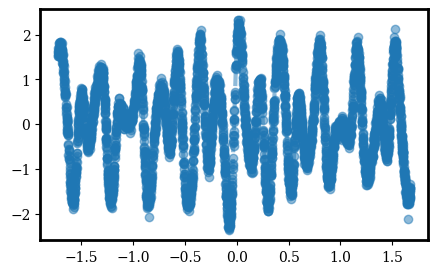

In [11]:
batch = (X, Y)

X_test = np.linspace(-1,1,400).reshape(-1,1)

Y_test = (target_fn(X_test) - mu_Y) / sigma_Y
X_test = (X_test - mu_X) / sigma_X

plt.figure(figsize = (5,3))
plt.plot(X_test, Y_test, linewidth = 3, linestyle = '--', alpha = 0.5, label = 'Target')
plt.scatter(X, Y, alpha = 0.5, label = 'Data')
plt.show()
plt.close()

In [12]:
layers = [X.shape[1], *[64 for _ in range(4)], 1]
activation = np.tanh
fit_model = MLPRegression(layers, activation = activation)

In [13]:
init_model = initNet(layers[:-1], activation = activation)
#init_model.plot_degree(init_model.scale_params, fit_model.net_params[:-1], X, word = False)

In [14]:
lr = 5e-3
init_fn, update_fn, get_params = optimizers.adam(lr)
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
lam = 5e-4
@jit
def step(i, state, X):
    key = random.PRNGKey(i)
    g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
    return update_fn(i, g, state)

In [15]:
opt_state = init_fn(init_model.scale_params)
init_nIter = 10000
pbar = trange(init_nIter)
scale_stor = []
bias_stor = []

for i in pbar:
    opt_state = step(i, opt_state, X)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), X)})
        scale_stor.append([w for (w, b) in params])
        bias_stor.append([b for (w, b) in params])
        

scale_stor = np.array(scale_stor)
bias_stor = np.array(bias_stor)
        


100%|██████████| 10000/10000 [00:08<00:00, 1119.80it/s, Log sine loss=0.30585468]


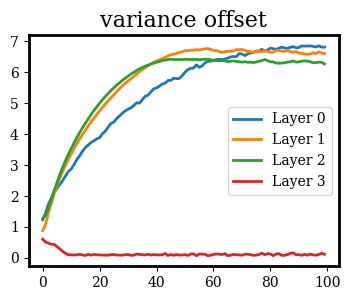

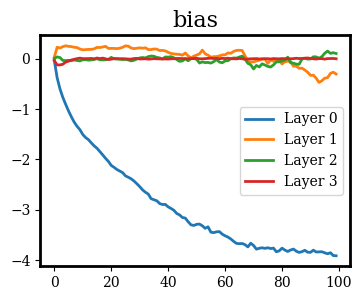

In [16]:
plt.figure(figsize = (4,3))
for i, s in enumerate(scale_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
plt.legend()
plt.title('variance offset')
plt.show()
plt.close()

plt.figure(figsize = (4,3))
for i, s in enumerate(bias_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
plt.legend()
plt.title('bias')
plt.show()
plt.close()

In [17]:
scale_params = params

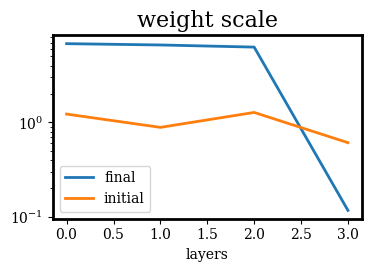

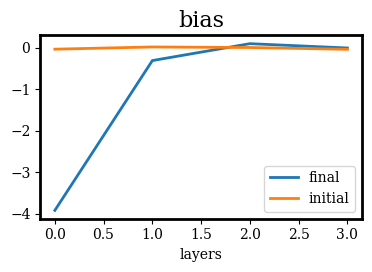

In [18]:
plt.figure(figsize = (4,3))

plt.plot([w_init for w_init, b_init in scale_params], label = 'final')
plt.plot([w_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.yscale('log')
plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))

plt.plot([b_init for w_init, b_init in scale_params], label = 'final')
plt.plot([b_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

In [19]:
fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

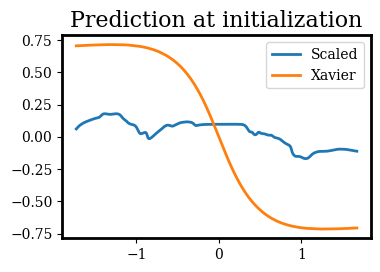

In [20]:
plt.figure(figsize = (4,3))
plt.plot(X_test, fit_model.net_apply(fit_model.scaled_net_params, X_test), label = 'Scaled')
plt.plot(X_test, fit_model.net_apply(fit_model.net_params, X_test), label = 'Xavier')
plt.title('Prediction at initialization')
plt.legend()
plt.tight_layout()
plt.savefig(path + 'initial.pdf', dpi = 200)
plt.show()
plt.close()

In [38]:
key = random.PRNGKey(3)

max_freq = 24
N_freq = 4
target_fn = fun_gen(key, max_freq, N_freq)

X = random.uniform(key, shape = (data_size, 1), minval = -1, maxval = 1)
Y = target_fn(X)
Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.05
mu_X, sigma_X = X.mean(0), X.std(0)
X = (X - mu_X) / sigma_X
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
Y = (Y - mu_Y) / sigma_Y

X_test = np.linspace(-1,1,400).reshape(-1,1)

Y_test = (target_fn(X_test) - mu_Y) / sigma_Y
X_test = (X_test - mu_X) / sigma_X

In [39]:
# lr = 1e-3
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)

init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(1e-3, decay_steps = 400, decay_rate = 0.99))
nIter = 80000
@jit
def step(i, state, batch):
    g = grad(fit_model.loss)(get_params(state), batch)
    return update_fn(i, g, state)

In [40]:
pbar = trange(nIter)

opt_state = init_fn(fit_model.scaled_net_params)

scaled_loss_stor = []

for i in pbar:
    opt_state = step(i, opt_state, (X, Y))
    if i % 100 == 0:
        params = get_params(opt_state)
        loss_val = fit_model.loss(params, (X, Y))
        
        scaled_loss_stor.append(loss_val)
        pbar.set_postfix({'loss': loss_val})
        
scaled_loss_stor = np.array(scaled_loss_stor)

100%|██████████| 80000/80000 [00:27<00:00, 2877.41it/s, loss=0.002453933] 


In [41]:
scaled_opt_params = params

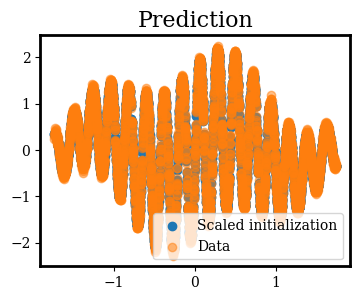

In [42]:
plt.figure(figsize = (4,3))

plt.scatter(X, fit_model.net_apply(params, X), label = 'Scaled initialization')
plt.scatter(X, Y, alpha = 0.5, label = 'Data')
plt.title('Prediction')
plt.legend()
plt.show()
plt.close()

In [43]:
def orthogonalize(H):
    n, d = H.shape
    sigma = np.dot(H.T, H)/(n-1)
    chol = np.linalg.cholesky(sigma + np.eye(d)*1e-5) 
    choli = np.linalg.inv(chol)
    H = np.matmul(H, choli.T)
    return H

def orthonormalize(H):
    n, d = H.shape
    sigma = np.dot(H.T, H)/(n-1)
    chol = np.linalg.cholesky(sigma + np.eye(d)*1e-5) 
    choli = np.linalg.inv(chol)
    H = np.matmul(H, choli.T)
    return H/np.linalg.norm(H, 2, axis=0)

# Define an MLP with orthogonal features
def OMLP(layers, offset=1.0):
    ''' Vanilla MLP'''
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt(d_in)
            W = offset * glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = np.tanh(outputs)
        W, b = params[-1]
        inputs = orthonormalize(inputs)
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply



In [53]:
class omlp:
    def __init__(self, layers, key, **kwargs):
        offset = kwargs['offset']
        print(offset)
        self.net_init, self.net_apply = OMLP(layers, offset)
        self.layers = layers
        self.key = key
        self.net_params = self.net_init(key)
        self.key = random.split(key)[0]
    def loss(self, params, batch):
        X, y = batch

        pred = self.net_apply(params, X).flatten()
        return ((pred - y.flatten())**2).mean()
    @partial(jit, static_argnums=(0,))
    def l2_error(self, params, batch):
        X, Y = batch
        
        pred = self.net_apply(params, X).flatten()
        
        return np.linalg.norm(Y.flatten() - pred) / np.linalg.norm(Y.flatten())

omlp_fit = omlp(layers, key, offset = 10.0)
@jit
def omlp_step(i, state, batch):
    g = grad(omlp_fit.loss)(get_params(state), batch)
    return update_fn(i, g, state)

10.0


In [54]:
pbar = trange(nIter)

opt_state = init_fn(omlp_fit.net_params)

omlp_loss_stor = []

for i in pbar:
    opt_state = step(i, opt_state, (X, Y))
    if i % 100 == 0:
        params = get_params(opt_state)
        loss_val = omlp_fit.loss(params, (X, Y))
        
        omlp_loss_stor.append(loss_val)
        pbar.set_postfix({'loss': loss_val})
        
omlp_loss_stor = np.array(omlp_loss_stor)

100%|██████████| 80000/80000 [00:31<00:00, 2502.16it/s, loss=0.88292086]


In [55]:
omlp_opt_params = params

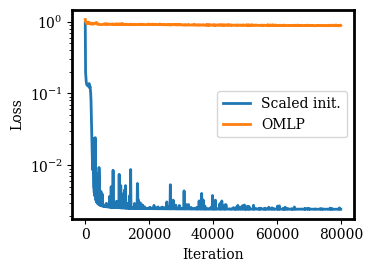

In [56]:
plt.figure(figsize = (4,3))
plt.plot(100 * np.arange(scaled_loss_stor.shape[0]), scaled_loss_stor, label = 'Scaled init.')
plt.plot(100 * np.arange(omlp_loss_stor.shape[0]), omlp_loss_stor, label = 'OMLP')
plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig(path + f'{int(max_freq)}_loss.pdf', dpi = 200)
plt.show()
plt.close()

In [57]:
np.save(path + 'train_data', np.array((X, Y)))
np.save(path + 'test_data', np.array((X_test, Y_test)))

In [58]:
with open(path + \
          f'{lam}_{max_freq}_errors.txt', "w") as text_file:
    text_file.write(f'initialization, train, test,\n')
    text_file.write(f'Xavier, {omlp_fit.l2_error(omlp_opt_params, (X, Y))}, {omlp_fit.l2_error(omlp_opt_params, (X_test, Y_test))}, \n')
    text_file.write(f'Scaled, {fit_model.l2_error(scaled_opt_params, (X, Y))}, {fit_model.l2_error(scaled_opt_params, (X_test, Y_test))}')


In [59]:
print(omlp_fit.l2_error(omlp_opt_params, (X, Y)), omlp_fit.l2_error(omlp_opt_params, (X_test, Y_test)))
print(fit_model.l2_error(scaled_opt_params, (X, Y)), fit_model.l2_error(scaled_opt_params, (X_test, Y_test)))

0.93954307 0.87306416
0.04953718 0.01116515


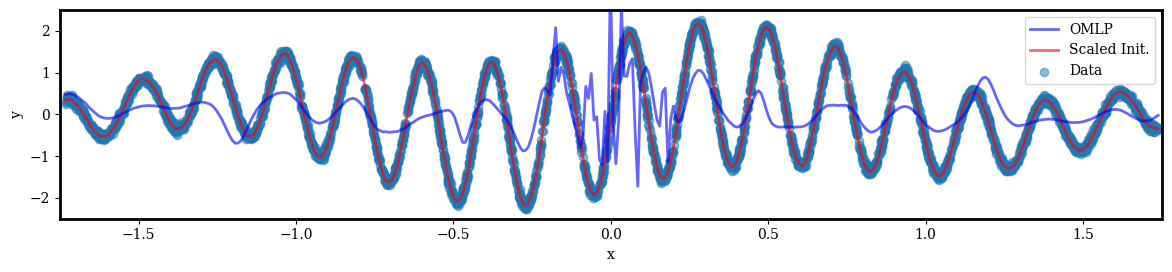

In [60]:
plt.figure(figsize = (12,3))
# plt.plot(X_test, Y_test, linewidth = 6, linestyle = '--', color = 'g', alpha = 0.5, label = 'Target', zorder = 0)
plt.scatter(X, Y, alpha = 0.5, label = 'Data', zorder = 1)
plt.plot(X_test, omlp_fit.net_apply(omlp_opt_params, X_test), color = 'b', linewidth = 2, label = 'OMLP', alpha = 0.6, zorder = 3)
plt.plot(X_test, fit_model.net_apply(scaled_opt_params, X_test), color = 'r', linewidth = 2, label = 'Scaled Init.', alpha = 0.6, zorder = 2)

# plt.axvspan(-1.73, -1.2, alpha=0.25, color='aqua', zorder = -1)
# plt.axvspan(-0.72, -0.52, alpha=0.25, color='aqua', zorder = -1)
# plt.axvspan(1.0, 1.37, alpha=0.25, color='aqua', zorder = -1)
# plt.axvspan(1.45, 1.73, alpha=0.25, color='aqua', zorder = -1)
plt.xlim([-1.75, 1.75])
plt.ylim([-2.5,2.5])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor = (1., 1.))
#plt.legend()
plt.tight_layout()
plt.savefig(path + f'{int(max_freq)}_fit.pdf', dpi = 100)
plt.show()
plt.close()

In [61]:
np.save(path + f'{lam}_{max_freq}_losses.npy', np.array((omlp_loss_stor, scaled_loss_stor)))